In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)

mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

# Предобработка данных

In [4]:
prices = prices.replace(0, np.nan)
mcap = mcap.replace(0, np.nan)
pe = pe.replace(0, np.nan)
volume = volume.replace(0, np.nan)
imoex = imoex.replace(0, np.nan)

In [5]:
liquidity_filter = pqr.Factor(volume).look_back() > 10_000_000

size = pqr.Factor(mcap).look_back(3).hold(3).filter(liquidity_filter)
value = pqr.Factor(pe).look_back(3).hold(3).filter(liquidity_filter)

benchmark = pqr.Benchmark('IMOEX').from_index(imoex['IMOEX'])

# Intercept Multifactor

Сначала строим два однофакторных портфеля с желаемыми квантилями.

In [6]:
size_portfolio = pqr.Portfolio('size q(0, 0.33)')
size_portfolio.pick_by_factor(size, (0, 0.33), better='less')

value_portfolio = pqr.Portfolio('value q(0, 0.33)')
value_portfolio.pick_by_factor(value, (0, 0.33), better='less')

Portfolio('value q(0, 0.33)')

Пусть основным портфелем будет портфель на основе фактора размера (для построения данной мультифакторной модели, какой именно из портфелей является основным, непринципиально). Тогда мы можем воспользоваться пост-фильтрацией позиций: фильтрующей маской в данном случае будет факт отбора в портфель на основе фактора стоимости.

In [7]:
intercept_portfolio = pqr.Portfolio('intercept size & value')
intercept_portfolio.pick_by_factor(size, (0, 0.33), better='less')
intercept_portfolio.filter(value_portfolio.picks == 1)

Portfolio('intercept size & value')

In [8]:
size_portfolio.weigh_equally()
size_portfolio.allocate(prices)

value_portfolio.weigh_equally()
value_portfolio.allocate(prices)

intercept_portfolio.weigh_equally()
intercept_portfolio.allocate(prices)

Portfolio('intercept size & value')

Из всех факторных портфелей лучшим оказался обычный value-портфель, size-портфель значительно проиграл рынку, а intercept-портфель оказался между ними, хотя тоже проиграл рынку.

/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

,"size q(0, 0.33)","value q(0, 0.33)",intercept size & value
"Total Return, %",282.20,1318.34,367.14
"Annual Return, %",8.16,16.79,9.44
"Annual Volatility, %",32.02,26.38,33.82
"Mean Return, %",1.10,1.59,1.24
"Win Rate, %",54.63,59.02,54.15
"Volatility, %",9.24,7.61,9.76
"Maximum Drawdown, %",-82.66,-66.05,-76.62
"VaR, %",-12.81,-9.37,-13.52
"Expected Tail Loss, %",-19.63,-14.86,-21.01
Rachev Ratio,1.09,1.30,1.06


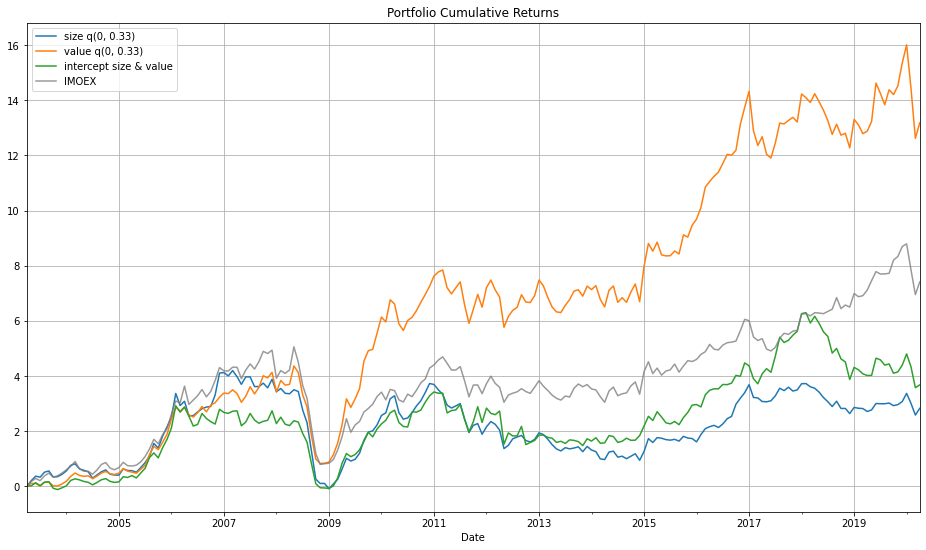

In [9]:
pqr.summary_tear_sheet([size_portfolio, value_portfolio, intercept_portfolio], benchmark)

# N-Sort Multifactor

Воспользуемся уже построенными нами ранее портфелями. Пусть опять первым сортирующим фактором будет фактор размера (теперь порядок выбора факторов уже важен). Тогда мы можем сначала построить однофакторный портфель на основе фактора размера, а затем отфильтровать фактор стоимости, после чего уже на основе отфильтрованного фактора стоимости построить портфель. 

In [10]:
nsort_portfolio = pqr.Portfolio('n-sort size & value')
value_filtered = value.filter(size_portfolio.picks == 1)
nsort_portfolio.pick_by_factor(value_filtered, (0, 0.33), better='less')

Portfolio('n-sort size & value')

In [11]:
nsort_portfolio.weigh_equally()
nsort_portfolio.allocate(prices)

Portfolio('n-sort size & value')

N-sort-портфель тоже оказался между факторами, которые лежали в основе его построения, однако показал себя лучше, чем intercept-портфель. Примечательно, что в период с 2006 по 2009 гг. он показал результат лучше всех портфелей, однако впоследствии остал от обычного фактора стоимости.

/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/akbabkin/programming/projects/pqr/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

,"size q(0, 0.33)","value q(0, 0.33)",intercept size & value,n-sort size & value
"Total Return, %",282.20,1318.34,367.14,519.75
"Annual Return, %",8.16,16.79,9.44,11.27
"Annual Volatility, %",32.02,26.38,33.82,34.01
"Mean Return, %",1.10,1.59,1.24,1.37
"Win Rate, %",54.63,59.02,54.15,52.68
"Volatility, %",9.24,7.61,9.76,9.82
"Maximum Drawdown, %",-82.66,-66.05,-76.62,-77.27
"VaR, %",-12.81,-9.37,-13.52,-12.30
"Expected Tail Loss, %",-19.63,-14.86,-21.01,-19.42
Rachev Ratio,1.09,1.30,1.06,1.25


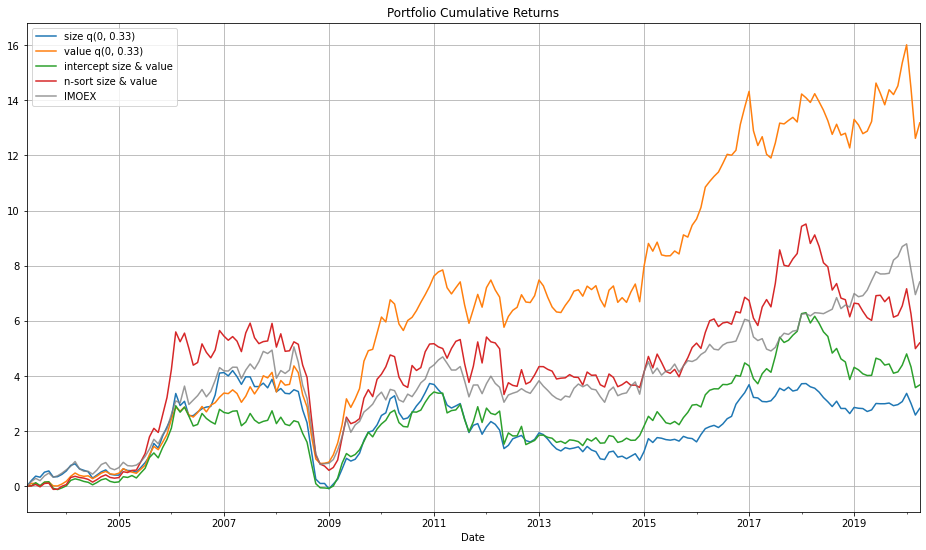

In [12]:
pqr.summary_tear_sheet([size_portfolio, value_portfolio, intercept_portfolio, nsort_portfolio], benchmark)